## $ \text{GNN : Inductive Representation Learning on Large Graphs} $ 

$\text{GraphSAGE}$ : Graph Neural Network에서 유명한 모델 중 하나이며, 2017년에 제안되었습니다. [Hamilton et al](https://arxiv.org/pdf/1706.02216.pdf)

![figure_2](asset/figure_2.JPG)

그래프에 관련된 연구는 계속진행되어 왔으며, 최근에는 [GCN](https://arxiv.org/pdf/1609.02907.pdf)을 통해 semi-supervised node classification을 수행하는 연구도 발표 되었습니다. 

본 tutorial에서는 Kipf's의 setting으로 데이터의 라벨을 예측합니다. 

In [1]:
from utils import load_zachery # data load
import time 

import dgl

import torch 
import torch.optim as optim 
import torch.nn as nn 


c:\Users\EonKim\anaconda3\envs\dgl\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load graph
g = load_zachery()

In [3]:
labels = g.ndata['club']
labeled_nodes = [0, 33]
print('Labels', labels[labeled_nodes])

Labels tensor([0, 1])


## $ \text{Define a GraphSAGE model} $ 

GraphSAGE는 이웃 노드들의 정보를 합계(aggregating)하여 노드의 표현(representation)을 업데이트 하는 형태로 진행합니다.

### $$ h^k_{\mathcal{N}(v)} \leftarrow \text{AGGEGATE}_k(h^{k-1}_u, \forall u \in \mathcal{N}(v))$$
### $$ h^k_v \leftarrow \sigma(W^k \cdot \text{CONCAT} (h^{k-1}_v, h^k_{N(v)})) $$

### $$ h^k_v \leftarrow \sigma( W \cdot \text{MEAN}(\{h^{k-1}_v \} \cup \{ h^{k-1_u} \forall u \in \mathcal{N}(v)\}) ) $$


DGL에서는 kipf's가 제안한 GCN 뿐만 아니라 SAGEConv 등 다양한 GCN 모델을 제공하고 있습니다.

In [4]:
from dgl.nn import SAGEConv

class GraphSAGE(nn.Module):
    def __init__(self, num_nodes, embed_dim, h_feats, num_classes):
        super(GraphSAGE, self).__init__()
        self.embeded = nn.Embedding(num_nodes, embed_dim)
        self.conv1 = SAGEConv(embed_dim, h_feats, 'mean') # normlization 부분을 mean으로 수행하였기 때문.
        self.conv2 = SAGEConv(h_feats, num_classes, 'mean')
        
        self.relu = nn.ReLU()
        
        self._init_weight()
        
    def forward(self, g):
        inputs = self.embeded.weight
        output = self.conv1(g, inputs)
        output = self.relu(output)
        output = self.conv2(g, output)
        return output 
    
    def _init_weight(self):
        for m in self.modules():              
            if isinstance(m, nn.Embedding):
                nn.init.xavier_uniform_(m.weight)

# num_nodes : number of nodes 
# embed_dim : node embeddings 
# h_feats : hidden layer dimension 
# num_classes : the two classes 0 and 1
models = GraphSAGE(num_nodes=g.number_of_nodes(), embed_dim=5, h_feats=16, num_classes=2)

In [5]:
# setting optimizer, criterion, and accuracy, elapsed_time 
optimizer = optim.Adam(models.parameters(), lr = 1e-2)

def criterion(pred, true, mask):
    cross_entropy = nn.CrossEntropyLoss()
    pred = pred[mask]
    true = true[mask]
    return cross_entropy(pred, true)

def calc_accuracy(pred, true):
    pred_y = torch.argmax(pred, dim=1)
    return (pred_y==true).sum().item() / len(pred)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time 
    elapsed_mins = int(elapsed_time / 60) 
    elapsed_secs = elapsed_time - elapsed_mins * 60 
    return elapsed_mins, elapsed_secs

In [6]:
num_epochs = 100
all_pred = []

for epoch in range(1, num_epochs + 1):
    start_time = time.time()
    models.train()
    
    optimizer.zero_grad()
    pred = models(g)
    all_pred.append(pred)
    loss = criterion(pred, labels, labeled_nodes)
    loss.backward()
    optimizer.step()
    acc = calc_accuracy(pred, labels)
    if (epoch) % 5 == 0:
        end_time = time.time()
        elapsed_mins, elapesd_secs = epoch_time(start_time, end_time)
        print(f'epoch [{epoch}/{num_epochs}] | elapsed time : {elapsed_mins}m, {elapesd_secs*5:.3f}s')
        print(f'train accuracy: {acc*100:.2f}%, train loss : {loss:.4f}\n')

c:\Users\EonKim\anaconda3\envs\dgl\lib\site-packages\torch\autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


epoch [5/100] | elapsed time : 0m, 0.053s
train accuracy: 52.94%, train loss : 0.5036

epoch [10/100] | elapsed time : 0m, 0.050s
train accuracy: 70.59%, train loss : 0.2294

epoch [15/100] | elapsed time : 0m, 0.055s
train accuracy: 67.65%, train loss : 0.0875

epoch [20/100] | elapsed time : 0m, 0.050s
train accuracy: 76.47%, train loss : 0.0304

epoch [25/100] | elapsed time : 0m, 0.055s
train accuracy: 82.35%, train loss : 0.0112

epoch [30/100] | elapsed time : 0m, 0.040s
train accuracy: 82.35%, train loss : 0.0048

epoch [35/100] | elapsed time : 0m, 0.045s
train accuracy: 85.29%, train loss : 0.0025

epoch [40/100] | elapsed time : 0m, 0.042s
train accuracy: 85.29%, train loss : 0.0015

epoch [45/100] | elapsed time : 0m, 0.050s
train accuracy: 88.24%, train loss : 0.0011

epoch [50/100] | elapsed time : 0m, 0.060s
train accuracy: 88.24%, train loss : 0.0008

epoch [55/100] | elapsed time : 0m, 0.044s
train accuracy: 88.24%, train loss : 0.0007

epoch [60/100] | elapsed time : 0

In [7]:
import matplotlib.pyplot as plt 

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.rcParams['figure.figsize'] = (4.0, 3.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['animation.html'] = 'html5'

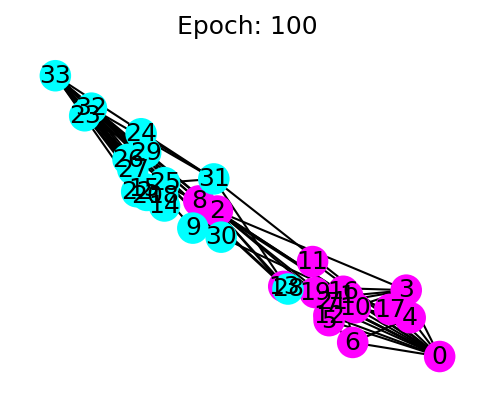

In [8]:
# 아래 코드가 작동되지 않는다면?
# conda install -c conda-forge ffmpeg

import networkx as nx 
import numpy as np 
import matplotlib.animation as animation 

from IPython.display import HTML 


fig = plt.figure(dpi=150)
fig.clf()
ax = fig.subplots()
nx_G = g.to_networkx()
def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    colors = []
    for v in range(34):
        pred = all_pred[i].detach().numpy()
        pos[v] = pred[v]
        cls = labels[v]
        colors.append(cls1color if cls else cls2color)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' %(i+1))
    nx.draw(nx_G.to_undirected(), pos, node_color=colors, with_labels=True, node_size=200)
    
ani = animation.FuncAnimation(fig, draw, frames=len(all_pred), interval=200)
ani.save('asset/animation.mp4')
HTML(ani.to_html5_video())